# Petr a vlk: Realistické prostředí

V naší situaci se Petr mohl pohybovat téměř bez únavy nebo hladu. V realističtějším světě si však musí čas od času sednout a odpočinout si, stejně jako se najíst. Udělejme náš svět realističtější zavedením následujících pravidel:

1. Při přesunu z jednoho místa na druhé Petr ztrácí **energii** a získává **únavu**.
2. Petr může získat více energie tím, že jí jablka.
3. Petr se může zbavit únavy odpočinkem pod stromem nebo na trávě (tj. vstupem na políčko s stromem nebo trávou - zelené pole).
4. Petr musí najít a zabít vlka.
5. Aby mohl vlka zabít, musí mít Petr určité úrovně energie a únavy, jinak prohraje souboj.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from rlboard import *

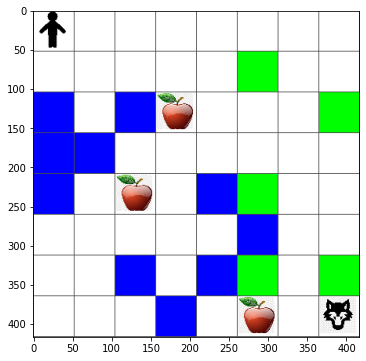

In [2]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

In [3]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

## Definování stavu

V našich nových pravidlech hry musíme sledovat energii a únavu v každém stavu hrací desky. Proto vytvoříme objekt `state`, který bude obsahovat všechny potřebné informace o aktuálním stavu problému, včetně stavu desky, aktuálních úrovní energie a únavy a také toho, zda můžeme porazit vlka v terminálním stavu:


In [4]:
class state:
    def __init__(self,board,energy=10,fatigue=0,init=True):
        self.board = board
        self.energy = energy
        self.fatigue = fatigue
        self.dead = False
        if init:
            self.board.random_start()
        self.update()

    def at(self):
        return self.board.at()

    def update(self):
        if self.at() == Board.Cell.water:
            self.dead = True
            return
        if self.at() == Board.Cell.tree:
            self.fatigue = 0
        if self.at() == Board.Cell.apple:
            self.energy = 10

    def move(self,a):
        self.board.move(a)
        self.energy -= 1
        self.fatigue += 1
        self.update()

    def is_winning(self):
        return self.energy > self.fatigue

Pojďme zkusit vyřešit problém pomocí náhodné procházky a uvidíme, zda uspějeme:


In [5]:
def random_policy(state):
    return random.choice(list(actions))

def walk(board,policy):
    n = 0 # number of steps
    s = state(board)
    while True:
        if s.at() == Board.Cell.wolf:
            if s.is_winning():
                return n # success!
            else:
                return -n # failure!
        if s.at() == Board.Cell.water:
            return 0 # died
        a = actions[policy(m)]
        s.move(a)
        n+=1

walk(m,random_policy)

0

In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        elif z==0:
            n+=1
        else:
            s+=1
    print(f"Killed by wolf = {w}, won: {s} times, drown: {n} times")

print_statistics(random_policy)

Killed by wolf = 5, won: 1 times, drown: 94 times


## Funkce odměny

Funkce odměny je klíčovou součástí procesu učení. Slouží k tomu, aby agentovi poskytla zpětnou vazbu o tom, jak dobře si vede při plnění daného úkolu.

### Jak funguje?

Funkce odměny přiřazuje číselnou hodnotu každé akci nebo sekvenci akcí, které agent provede. Tato hodnota reprezentuje, jak „dobrá“ nebo „špatná“ byla daná akce z hlediska dosažení cíle.

### Příklady odměn

- **Pozitivní odměna:** Pokud agent dosáhne cíle nebo provede akci, která ho k cíli přiblíží, může získat kladnou odměnu.  
- **Negativní odměna:** Pokud agent provede akci, která ho od cíle vzdálí, nebo poruší pravidla, může být penalizován zápornou odměnou.  
- **Žádná odměna:** V některých případech může být odměna nulová, což znamená, že akce neměla žádný významný dopad.

### Návrh funkce odměny

Při návrhu funkce odměny je důležité zajistit, aby:

1. **Byla jasná a konzistentní:** Agent by měl snadno pochopit, jaké chování je žádoucí.  
2. **Podporovala požadované chování:** Funkce odměny by měla motivovat agenta k dosažení cíle efektivním způsobem.  
3. **Zohledňovala vedlejší efekty:** Je třeba dávat pozor, aby agent nebyl motivován k nežádoucímu chování, které sice maximalizuje odměnu, ale není v souladu s cílem.

### Časté chyby

- **Příliš složitá funkce odměny:** Pokud je funkce odměny příliš komplikovaná, může být pro agenta obtížné pochopit, jak optimalizovat své chování.  
- **Nedostatečné pokrytí scénářů:** Funkce odměny by měla zohledňovat všechny možné situace, se kterými se agent může setkat.  
- **Neúmyslné odměňování špatného chování:** Pokud funkce odměny není správně navržena, může agent najít způsoby, jak maximalizovat odměnu, aniž by skutečně plnil požadovaný úkol.

### Závěr

Funkce odměny je základním stavebním kamenem každého systému posilovaného učení. Správně navržená funkce odměny může výrazně zlepšit výkon agenta a zajistit, že dosáhne požadovaných výsledků.


In [7]:
def reward(s):
    r = s.energy-s.fatigue
    if s.at()==Board.Cell.wolf:
        return 100 if s.is_winning() else -100
    if s.at()==Board.Cell.water:
        return -100
    return r

## Algoritmus Q-Learning

Samotný učící algoritmus zůstává téměř nezměněn, pouze používáme `state` místo pouhé pozice na desce.


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

In [9]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

In [10]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    s = state(m)
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = s.board.human
        v = probs(Q[x,y])
        while True:
            a = random.choices(list(actions),weights=v)[0]
            dpos = actions[a]
            if s.board.is_valid(s.board.move_pos(s.board.human,dpos)):
                break 
        s.move(dpos)
        r = reward(s)
        if abs(r)==100: # end of game
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

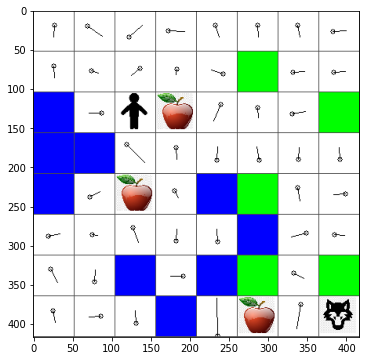

In [11]:
m.plot(Q)

## Výsledky

Podívejme se, zda se nám podařilo naučit Petra bojovat s vlkem!


In [12]:
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Killed by wolf = 1, won: 9 times, drown: 90 times


Nyní vidíme mnohem méně případů utonutí, ale Peter stále není vždy schopen zabít vlka. Zkuste experimentovat a zjistit, zda můžete tento výsledek zlepšit úpravou hyperparametrů.


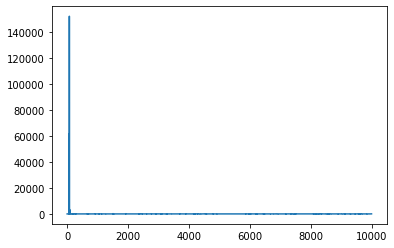

In [13]:
plt.plot(lpath)


---

**Upozornění**:  
Tento dokument byl přeložen pomocí služby pro automatický překlad [Co-op Translator](https://github.com/Azure/co-op-translator). I když se snažíme o co největší přesnost, mějte prosím na paměti, že automatické překlady mohou obsahovat chyby nebo nepřesnosti. Původní dokument v jeho původním jazyce by měl být považován za závazný zdroj. Pro důležité informace doporučujeme profesionální lidský překlad. Neodpovídáme za žádná nedorozumění nebo nesprávné výklady vyplývající z použití tohoto překladu.
